In [1]:
import pandas as pd
import os
from IPython.display import display, Markdown # For explicitly controlling display and adding text
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Patch
import seaborn as sns
import numpy as np
from scipy import stats
import statsmodels.formula.api as smf
from datetime import timedelta
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
file_path_1 = r'C:\Users\REALD\Documents\RIA\caiso_curtailment.csv'
file_path_2 = r'C:\Users\REALD\Documents\RIA\caiso_standard.csv'
file_path_3 = r'C:\Users\REALD\Documents\RIA\caiso_renewable_forecast.csv'
file_path_4 = r'C:\Users\REALD\Documents\RIA\caiso_load_forecast.csv'
file_path_5 = r'C:\Users\REALD\Documents\RIA\caiso_lmp.csv'

curtailment = pd.read_csv(file_path_1)
data = pd.read_csv(file_path_2)
renewable = pd.read_csv(file_path_3)
load = pd.read_csv(file_path_4)
lmp = pd.read_csv(file_path_5)

In [3]:
for x in [curtailment, data, renewable, load, lmp]:
    x.drop('interval_start_local', axis=1, inplace=True)
    x.drop('interval_end_local', axis=1, inplace=True)
    x.drop('interval_end_utc', axis=1, inplace=True)
    x['interval_start_utc'] = pd.to_datetime(x['interval_start_utc'])

In [4]:
renewable['publish_time_utc'] = pd.to_datetime(renewable['publish_time_utc'])

In [5]:
renewable = renewable.loc[renewable.groupby('interval_start_utc')['publish_time_utc'].idxmax()]

In [6]:
lmp_avg = lmp.groupby('interval_start_utc')[['lmp', 'energy', 'congestion', 'loss', 'ghg']].mean().reset_index()

In [7]:
# list of the columns you want diffs for
cols = ['lmp', 'energy', 'congestion', 'loss', 'ghg']

# compute max – min per interval
lmp_diffs = (
    lmp
    .groupby('interval_start_utc')[cols]
    .max()
    .subtract(
        lmp.groupby('interval_start_utc')[cols].min()
    )
    .rename(columns=lambda c: f"{c}_diff")
    .reset_index()
)

# diffs now has columns: interval_start_utc, lmp_diff, energy_diff, congestion_diff, loss_diff, ghg_diff
lmp_diffs.head(5)

,interval_start_utc,lmp_diff,energy_diff,congestion_diff,loss_diff,ghg_diff
0,2022-01-01 08:00:00+00:00,1.877925,0.0,0.0,1.877925,0.0
1,2022-01-01 09:00:00+00:00,0.000000,0.0,0.0,0.000000,0.0
2,2022-01-01 10:00:00+00:00,1.535882,0.0,0.0,1.535883,0.0
3,2022-01-01 11:00:00+00:00,2.526922,0.0,0.0,2.526930,0.0
4,2022-01-01 12:00:00+00:00,2.743608,0.0,0.0,2.743603,0.0


In [8]:
curtailmentx = curtailment.groupby(['interval_start_utc', 'fuel_type'])[['curtailment_mwh', 'curtailment_mw']].sum().reset_index()

In [9]:
curtailment_grouped = curtailmentx.groupby(['interval_start_utc'])[['curtailment_mwh', 'curtailment_mw']].sum().reset_index()

In [10]:
curtailment_solar = curtailmentx[curtailmentx['fuel_type'] == 'Solar'].copy()

In [11]:
curtailment_wind = curtailmentx[curtailmentx['fuel_type'] == 'Wind'].copy()

In [12]:
load['net_load_forecast'] = load['load_forecast'] - renewable['solar_mw'] - renewable['wind_mw']

In [13]:
load.drop(['publish_time_local', 'publish_time_utc', 'tac_area_name'], axis=1, inplace=True)
load.columns.tolist()

['interval_start_utc', 'load_forecast', 'net_load_forecast']

In [14]:
renewable.drop(['location', 'publish_time_local', 'publish_time_utc'], axis=1, inplace=True)
renewable.columns.tolist()

['interval_start_utc', 'solar_mw', 'wind_mw']

In [15]:
curtailment_grouped.drop(['curtailment_mwh'], axis=1, inplace=True)
curtailment_grouped.rename(columns={'curtailment_mw': 'total_curtailment_mw'}, inplace=True)
curtailment_grouped.columns.tolist()

['interval_start_utc', 'total_curtailment_mw']

In [16]:
curtailment_solar.rename(columns={'curtailment_mw' : 'solar_curtailment_mw'}, inplace=True)
curtailment_solar.drop(['fuel_type', 'curtailment_mwh'], axis=1, inplace=True)
curtailment_solar.columns.tolist()

['interval_start_utc', 'solar_curtailment_mw']

In [17]:
curtailment_wind.rename(columns={'curtailment_mw' : 'wind_curtailment_mw'}, inplace=True)
curtailment_wind.drop(['fuel_type', 'curtailment_mwh'], axis=1, inplace=True)
curtailment_wind.columns.tolist()

['interval_start_utc', 'wind_curtailment_mw']

In [18]:
data['total_generation'] = data.filter(like='fuel_mix.').sum(axis=1)

In [19]:
df = pd.merge(data, load, on='interval_start_utc', how='inner')
df = pd.merge(df, renewable, on='interval_start_utc', how='inner')
df = pd.merge(df, curtailment_grouped, on='interval_start_utc', how='left')
df = pd.merge(df, curtailment_solar, on='interval_start_utc', how='left')
df = pd.merge(df, curtailment_wind, on='interval_start_utc', how='left')
df = pd.merge(df, lmp_avg, on='interval_start_utc', how='inner')
df = pd.merge(df, lmp_diffs, on='interval_start_utc', how='inner')

In [20]:
# 1b) any interval with no row in curtailment_grouped now has NaN → make that 0
df['total_curtailment_mw'] = df['total_curtailment_mw'].fillna(0)
df['solar_curtailment_mw'] = df['solar_curtailment_mw'].fillna(0)
df['wind_curtailment_mw'] = df['wind_curtailment_mw'].fillna(0)

# 1c) compute percent
df['percent'] = df['total_curtailment_mw'] / df['total_generation']

In [21]:
df['interval_pacific'] = df['interval_start_utc'].dt.tz_convert('America/Los_Angeles')

In [22]:
df.drop(['interval_start_utc'], axis=1, inplace=True)

In [23]:
# 2a) Extract day‐of‐week as a string
df['day_of_week'] = df['interval_pacific'].dt.day_name()  # Monday, Tuesday, …

# 2b) Extract month as integer (1–12) and hour
df['month'] = df['interval_pacific'].dt.month          # 1, 2, …, 12
df['hour']  = df['interval_pacific'].dt.hour           # 0, 1, …, 23

# 3) One‐hot encode
dow_dummies    = pd.get_dummies(df['day_of_week'], prefix='dow')
month_dummies  = pd.get_dummies(df['month'],          prefix='month')
hour_dummies   = pd.get_dummies(df['hour'],           prefix='hour')

# 4) Append back onto your DataFrame
df = pd.concat([df, dow_dummies, month_dummies, hour_dummies], axis=1)

In [24]:
df.head(5)

,load_forecast.load_forecast,net_load,renewables,renewables_to_load_ratio,load.load,fuel_mix.solar,fuel_mix.wind,fuel_mix.geothermal,fuel_mix.biomass,fuel_mix.biogas,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,22664.759167,18229.750000,6543.916667,0.295315,22159.083333,-31.916667,3961.250000,879.000000,274.583333,210.000000,...,False,False,False,False,False,False,False,False,False,False
1,21823.094167,17812.750000,6184.000000,0.289143,21387.333333,-32.000000,3606.583333,877.666667,280.750000,210.833333,...,False,False,False,False,False,False,False,False,False,False
2,21163.079167,17657.333333,5710.583333,0.274644,20792.666667,-32.000000,3167.333333,877.333333,282.166667,210.500000,...,False,False,False,False,False,False,False,False,False,False
3,20790.173125,17527.750000,5237.166667,0.256553,20413.583333,-33.166667,2919.000000,877.500000,279.666667,210.750000,...,False,False,False,False,False,False,False,False,False,False
4,20750.285833,17761.583333,5028.333333,0.246314,20414.333333,-33.083333,2685.833333,879.250000,282.333333,211.000000,...,False,False,False,False,False,False,False,False,False,False


In [25]:
# rename everything like "fuel_mix.solar" → "fuel_mix_solar"
df = df.rename(columns=lambda c: c.replace('.', '_'))

# now your predictors can be written normally:
formula = (
    'np.log(percent.clip(lower=1e-6)) ~ load_forecast_load_forecast + net_load + '
    'renewables + renewables_to_load_ratio + load_load + '
    'fuel_mix_solar + fuel_mix_wind + fuel_mix_geothermal + '
    'fuel_mix_biomass + fuel_mix_biogas + fuel_mix_small_hydro + '
    'fuel_mix_coal + fuel_mix_nuclear + fuel_mix_natural_gas + '
    'fuel_mix_large_hydro + fuel_mix_batteries + fuel_mix_imports + '
    'total_generation + load_forecast + net_load_forecast + '
    'solar_mw + wind_mw + total_curtailment_mw + '
    'solar_curtailment_mw + wind_curtailment_mw + '
    'lmp + energy + congestion + loss + '
    'lmp_diff + energy_diff + congestion_diff + loss_diff + '
    'C(day_of_week) + C(month) + C(hour)'
)

model = smf.ols(formula, data=df).fit()
print(model.summary())

# back‐transform
log_preds   = model.predict(df)
percent_hat = np.exp(log_preds)


                                   OLS Regression Results                                   
Dep. Variable:     np.log(percent.clip(lower=1e-6))   R-squared:                       0.794
Model:                                          OLS   Adj. R-squared:                  0.793
Method:                               Least Squares   F-statistic:                     1125.
Date:                              Tue, 08 Jul 2025   Prob (F-statistic):               0.00
Time:                                      02:54:15   Log-Likelihood:                -45020.
No. Observations:                             20765   AIC:                         9.018e+04
Df Residuals:                                 20693   BIC:                         9.076e+04
Df Model:                                        71                                         
Covariance Type:                          nonrobust                                         
                                  coef    std err          t      P>|t

In [26]:
df.columns

Index(['load_forecast_load_forecast', 'net_load', 'renewables',
       'renewables_to_load_ratio', 'load_load', 'fuel_mix_solar',
       'fuel_mix_wind', 'fuel_mix_geothermal', 'fuel_mix_biomass',
       'fuel_mix_biogas', 'fuel_mix_small_hydro', 'fuel_mix_coal',
       'fuel_mix_nuclear', 'fuel_mix_natural_gas', 'fuel_mix_large_hydro',
       'fuel_mix_batteries', 'fuel_mix_imports', 'fuel_mix_other',
       'total_generation', 'load_forecast', 'net_load_forecast', 'solar_mw',
       'wind_mw', 'total_curtailment_mw', 'solar_curtailment_mw',
       'wind_curtailment_mw', 'lmp', 'energy', 'congestion', 'loss', 'ghg',
       'lmp_diff', 'energy_diff', 'congestion_diff', 'loss_diff', 'ghg_diff',
       'percent', 'interval_pacific', 'day_of_week', 'month', 'hour',
       'dow_Friday', 'dow_Monday', 'dow_Saturday', 'dow_Sunday',
       'dow_Thursday', 'dow_Tuesday', 'dow_Wednesday', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'mont

In [27]:
df.set_index('interval_pacific', inplace=True)
print(df.index.dtype)

datetime64[ns, America/Los_Angeles]


In [34]:
df = df.drop(['day_of_week', 'month', 'hour'], axis=1)

In [35]:
df.columns

Index(['load_forecast_load_forecast', 'net_load', 'renewables',
       'renewables_to_load_ratio', 'load_load', 'fuel_mix_solar',
       'fuel_mix_wind', 'fuel_mix_geothermal', 'fuel_mix_biomass',
       'fuel_mix_biogas', 'fuel_mix_small_hydro', 'fuel_mix_coal',
       'fuel_mix_nuclear', 'fuel_mix_natural_gas', 'fuel_mix_large_hydro',
       'fuel_mix_batteries', 'fuel_mix_imports', 'fuel_mix_other',
       'total_generation', 'load_forecast', 'net_load_forecast', 'solar_mw',
       'wind_mw', 'total_curtailment_mw', 'solar_curtailment_mw',
       'wind_curtailment_mw', 'lmp', 'energy', 'congestion', 'loss', 'ghg',
       'lmp_diff', 'energy_diff', 'congestion_diff', 'loss_diff', 'ghg_diff',
       'percent', 'dow_Friday', 'dow_Monday', 'dow_Saturday', 'dow_Sunday',
       'dow_Thursday', 'dow_Tuesday', 'dow_Wednesday', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12', 'hour_0', 'hour_1

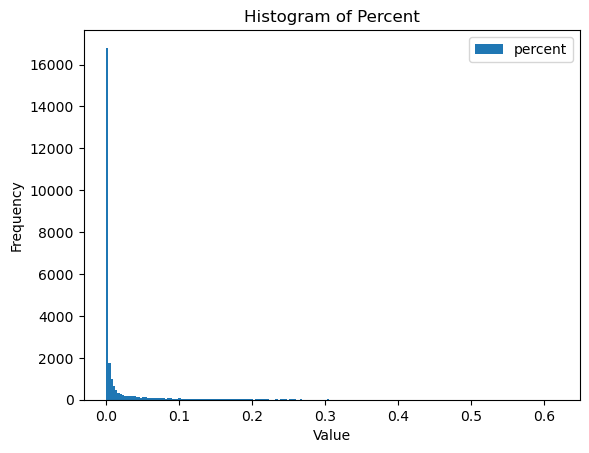

In [42]:
df.plot.hist(column='percent', bins=200)
plt.title('Histogram of Percent')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [46]:
uniq = df['percent'].dropna().unique()
if len(uniq) < 2:
    second_smallest = None
else:
    second_smallest = np.sort(uniq)[1]

print("Second-smallest distinct value:", second_smallest)

Second-smallest distinct value: 2.4987662341718777e-05



Threshold 2e-05: class balance → {1: 0.5359190556492411, 0: 0.46408094435075886}


C:\Users\REALD\anaconda3\envs\gridstatus\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:54:14] WARNING: D:\bld\xgboost-split_1745056718345\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\REALD\anaconda3\envs\gridstatus\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:54:15] WARNING: D:\bld\xgboost-split_1745056718345\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\REALD\anaconda3\envs\gridstatus\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:54:15] WARNING: D:\bld\xgboost-split_1745056718345\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\REALD\anaconda3\envs\gridstatus\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:54:16] WARNING: D:\bld\xgboost-split_1745056718345\work\src\learner.cc:738: 
Par


Threshold 5e-05: class balance → {1: 0.530185497470489, 0: 0.46981450252951096}


C:\Users\REALD\anaconda3\envs\gridstatus\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:54:54] WARNING: D:\bld\xgboost-split_1745056718345\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\REALD\anaconda3\envs\gridstatus\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:54:55] WARNING: D:\bld\xgboost-split_1745056718345\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\REALD\anaconda3\envs\gridstatus\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:54:55] WARNING: D:\bld\xgboost-split_1745056718345\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\REALD\anaconda3\envs\gridstatus\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:54:56] WARNING: D:\bld\xgboost-split_1745056718345\work\src\learner.cc:738: 
Par


Threshold 0.0001: class balance → {1: 0.5194892796916406, 0: 0.48051072030835945}


C:\Users\REALD\anaconda3\envs\gridstatus\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:55:36] WARNING: D:\bld\xgboost-split_1745056718345\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\REALD\anaconda3\envs\gridstatus\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:55:37] WARNING: D:\bld\xgboost-split_1745056718345\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\REALD\anaconda3\envs\gridstatus\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:55:37] WARNING: D:\bld\xgboost-split_1745056718345\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\REALD\anaconda3\envs\gridstatus\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:55:38] WARNING: D:\bld\xgboost-split_1745056718345\work\src\learner.cc:738: 
Par


Threshold 0.001: class balance → {0: 0.5870392676463503, 1: 0.4129607323536497}


C:\Users\REALD\anaconda3\envs\gridstatus\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:56:26] WARNING: D:\bld\xgboost-split_1745056718345\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\REALD\anaconda3\envs\gridstatus\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:56:26] WARNING: D:\bld\xgboost-split_1745056718345\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\REALD\anaconda3\envs\gridstatus\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:56:27] WARNING: D:\bld\xgboost-split_1745056718345\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\REALD\anaconda3\envs\gridstatus\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:56:28] WARNING: D:\bld\xgboost-split_1745056718345\work\src\learner.cc:738: 
Par


Threshold 0.01: class balance → {0: 0.7662250060226451, 1: 0.23377499397735485}


C:\Users\REALD\anaconda3\envs\gridstatus\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:57:13] WARNING: D:\bld\xgboost-split_1745056718345\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\REALD\anaconda3\envs\gridstatus\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:57:14] WARNING: D:\bld\xgboost-split_1745056718345\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\REALD\anaconda3\envs\gridstatus\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:57:14] WARNING: D:\bld\xgboost-split_1745056718345\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\REALD\anaconda3\envs\gridstatus\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:57:15] WARNING: D:\bld\xgboost-split_1745056718345\work\src\learner.cc:738: 
Par


Cross-validation summary:
     threshold               model  accuracy_mean  roc_auc_mean  \
0     0.00002                 KNN       0.867887      0.931581   
1     0.00002        RandomForest       1.000000      1.000000   
2     0.00002             XGBoost       1.000000      1.000000   
3     0.00002  LogisticRegression       0.940207      0.986687   
4     0.00005                 KNN       0.868706      0.932918   
5     0.00005        RandomForest       0.999855      0.999968   
6     0.00005             XGBoost       0.999855      1.000000   
7     0.00005  LogisticRegression       0.942954      0.988601   
8     0.00010                 KNN       0.873910      0.933818   
9     0.00010        RandomForest       0.998988      0.999967   
10    0.00010             XGBoost       0.999759      0.999999   
11    0.00010  LogisticRegression       0.946712      0.990417   
12    0.00100                 KNN       0.921127      0.960430   
13    0.00100        RandomForest       0.996531

C:\Users\REALD\anaconda3\envs\gridstatus\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:57:25] WARNING: D:\bld\xgboost-split_1745056718345\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\REALD\anaconda3\envs\gridstatus\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:57:34] WARNING: D:\bld\xgboost-split_1745056718345\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\REALD\anaconda3\envs\gridstatus\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:57:43] WARNING: D:\bld\xgboost-split_1745056718345\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\REALD\anaconda3\envs\gridstatus\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:57:53] WARNING: D:\bld\xgboost-split_1745056718345\work\src\learner.cc:738: 
Par

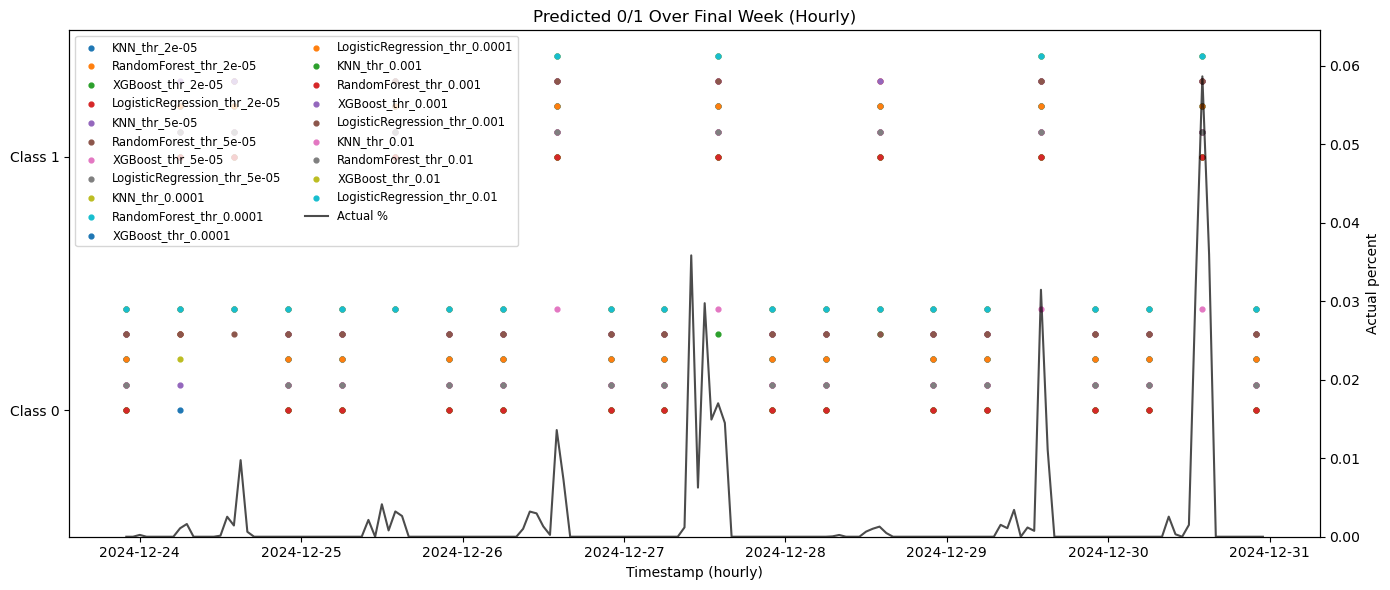

In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.pipeline       import Pipeline
from sklearn.impute         import SimpleImputer
from sklearn.preprocessing  import StandardScaler
from sklearn.neighbors      import KNeighborsClassifier
from sklearn.ensemble       import RandomForestClassifier
from xgboost                import XGBClassifier
from sklearn.linear_model   import LogisticRegression

# 1) Prepare features & target
X = df.drop(columns=['percent'], errors='ignore')
y_cont = df['percent']

# drop any row with missing data
X_clean = X.dropna(axis=0, how='any')
y_clean = y_cont.loc[X_clean.index]

# 2) Define thresholds, CV splitter, models, scoring
thresholds = [0.00002, 0.00005, 0.0001, 0.001, 0.01]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models = {
    'KNN': Pipeline([
        ('imp',   SimpleImputer(strategy='median')),
        ('scale', StandardScaler()),
        ('mdl',   KNeighborsClassifier(n_neighbors=5))
    ]),
    'RandomForest': Pipeline([
        ('imp', SimpleImputer(strategy='median')),
        ('mdl', RandomForestClassifier(n_estimators=100, random_state=42))
    ]),
    'XGBoost': Pipeline([
        ('imp', SimpleImputer(strategy='median')),
        ('mdl', XGBClassifier(use_label_encoder=False,
                              eval_metric='logloss',
                              random_state=42))
    ]),
    'LogisticRegression': Pipeline([
        ('imp',   SimpleImputer(strategy='median')),
        ('scale', StandardScaler()),
        ('mdl',   LogisticRegression(max_iter=1000, random_state=42))
    ]),
}

scoring = [
    'accuracy',
    'roc_auc',
    'precision',
    'recall',
    'f1',
    'average_precision',    # PR-AUC
    'balanced_accuracy',
    'neg_log_loss',
    'neg_brier_score',
]

# 3) Cross-validate over thresholds & models
results = []
for thr in thresholds:
    y = (y_clean > thr).astype(int)
    print(f"\nThreshold {thr}: class balance →", 
          y.value_counts(normalize=True).to_dict())
    for name, pipe in models.items():
        cv_res = cross_validate(pipe, X_clean, y,
                                cv=cv,
                                scoring=scoring,
                                return_train_score=False)
        row = {'threshold': thr, 'model': name}
        for metric in scoring:
            row[f"{metric}_mean"] = cv_res[f"test_{metric}"].mean()
        results.append(row)

results_df = pd.DataFrame(results)
print("\nCross-validation summary:\n", results_df)

# 4) Hold-out: last 7 days (168 h)
last_ts    = X_clean.index.max()
test_start = (last_ts - pd.Timedelta(days=7)).ceil('h')
train_end  = test_start - pd.Timedelta(hours=1)

X_train    = X_clean.loc[:train_end]
X_test     = X_clean.loc[test_start:]
y_train_ct = y_clean.loc[:train_end]
y_test_cont= y_cont.loc[test_start:]

# Gather predictions for that week
preds = pd.DataFrame(index=X_test.index)
for thr in thresholds:
    y_train = (y_train_ct > thr).astype(int)
    for name, pipe in models.items():
        pipe.fit(X_train, y_train)
        preds[f"{name}_thr_{thr}"] = pipe.predict(X_test)

# 5) Plot hourly predictions + actual percent
fig, ax = plt.subplots(figsize=(14,6))
n_thr = len(thresholds)

# scatter predicted 0/1, offset by threshold-index
for i, col in enumerate(preds.columns):
    thr = float(col.split('_')[-1])
    offset = thresholds.index(thr) * 0.1
    ax.scatter(
        preds.index, 
        preds[col] + offset, 
        s=12, 
        label=col
    )

ax.set_yticks([0,1])
ax.set_yticklabels(['Class 0','Class 1'])
ax.set_ylim(-0.5, 1 + 0.1*n_thr)
ax.set_xlabel("Timestamp (hourly)")
ax.set_title("Predicted 0/1 Over Final Week (Hourly)")

# overlay actual percent on twin y-axis
ax2 = ax.twinx()
ax2.plot(
    y_test_cont.index,
    y_test_cont,
    color='black',
    lw=1.5,
    alpha=0.7,
    label='Actual %'
)
ax2.set_ylabel("Actual percent")
ax2.set_ylim(y_test_cont.min()*0.9, y_test_cont.max()*1.1)

# combined legend
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax2.legend(h1+h2, l1+l2, loc='upper left', ncol=2, fontsize='small')

plt.tight_layout()
plt.show()


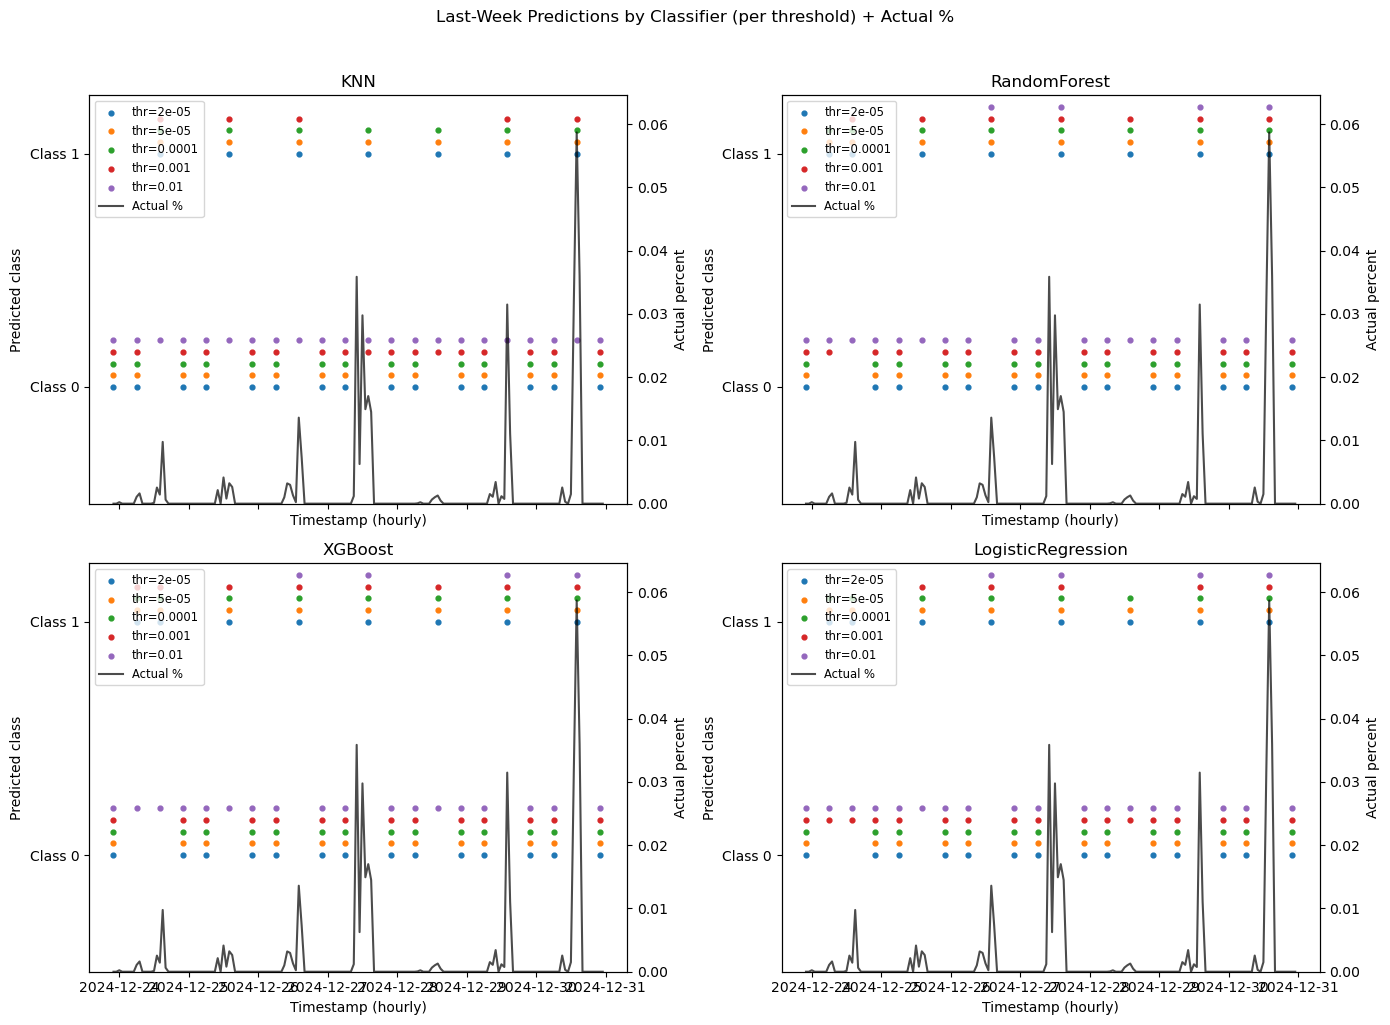

In [78]:
import matplotlib.pyplot as plt

# preds: DataFrame of shape (hours_in_last_week × (4*len(thresholds)))  
# y_test_cont: Series of actual percent over the last week  
# thresholds: your list of thresholds  
# models: dict of your four pipelines, e.g. {'KNN':…, 'RandomForest':…, …}

fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True)
axes = axes.flatten()

for ax, model_name in zip(axes, models.keys()):
    # scatter each threshold for this classifier
    for i, thr in enumerate(thresholds):
        col = f"{model_name}_thr_{thr}"
        offset = i * 0.05
        ax.scatter(
            preds.index,
            preds[col] + offset,
            s=12,
            label=f"thr={thr}"
        )
    
    ax.set_title(model_name)
    ax.set_yticks([0,1])
    ax.set_yticklabels(['Class 0','Class 1'])
    ax.set_ylim(-0.5, 1 + 0.05*len(thresholds))
    ax.set_ylabel("Predicted class")
    
    # overlay actual percent on twin y-axis
    ax2 = ax.twinx()
    line, = ax2.plot(
        y_test_cont.index,
        y_test_cont,
        color='black',
        lw=1.5,
        alpha=0.7,
        label='Actual %'
    )
    ax2.set_ylabel("Actual percent")
    ax2.set_ylim(y_test_cont.min()*0.9, y_test_cont.max()*1.1)
    
    # combine legends
    h1, l1 = ax.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax.legend(h1 + [line], l1 + l2, loc='upper left', fontsize='small')

# common x-label and title
for ax in axes:
    ax.set_xlabel("Timestamp (hourly)")

fig.suptitle("Last‐Week Predictions by Classifier (per threshold) + Actual %", y=1.02)
plt.tight_layout()
plt.show()


what is going awn

In [49]:
df.columns

Index(['load_forecast_load_forecast', 'net_load', 'renewables',
       'renewables_to_load_ratio', 'load_load', 'fuel_mix_solar',
       'fuel_mix_wind', 'fuel_mix_geothermal', 'fuel_mix_biomass',
       'fuel_mix_biogas', 'fuel_mix_small_hydro', 'fuel_mix_coal',
       'fuel_mix_nuclear', 'fuel_mix_natural_gas', 'fuel_mix_large_hydro',
       'fuel_mix_batteries', 'fuel_mix_imports', 'fuel_mix_other',
       'total_generation', 'load_forecast', 'net_load_forecast', 'solar_mw',
       'wind_mw', 'total_curtailment_mw', 'solar_curtailment_mw',
       'wind_curtailment_mw', 'lmp', 'energy', 'congestion', 'loss', 'ghg',
       'lmp_diff', 'energy_diff', 'congestion_diff', 'loss_diff', 'ghg_diff',
       'percent', 'dow_Friday', 'dow_Monday', 'dow_Saturday', 'dow_Sunday',
       'dow_Thursday', 'dow_Tuesday', 'dow_Wednesday', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12', 'hour_0', 'hour_1

In [76]:
fd = df.drop(['total_curtailment_mw', 'solar_curtailment_mw', 'wind_curtailment_mw'], axis=1)

In [80]:
fd.columns

Index(['load_forecast_load_forecast', 'net_load', 'renewables',
       'renewables_to_load_ratio', 'load_load', 'fuel_mix_solar',
       'fuel_mix_wind', 'fuel_mix_geothermal', 'fuel_mix_biomass',
       'fuel_mix_biogas', 'fuel_mix_small_hydro', 'fuel_mix_coal',
       'fuel_mix_nuclear', 'fuel_mix_natural_gas', 'fuel_mix_large_hydro',
       'fuel_mix_batteries', 'fuel_mix_imports', 'fuel_mix_other',
       'total_generation', 'load_forecast', 'net_load_forecast', 'solar_mw',
       'wind_mw', 'lmp', 'energy', 'congestion', 'loss', 'ghg', 'lmp_diff',
       'energy_diff', 'congestion_diff', 'loss_diff', 'ghg_diff', 'percent',
       'dow_Friday', 'dow_Monday', 'dow_Saturday', 'dow_Sunday',
       'dow_Thursday', 'dow_Tuesday', 'dow_Wednesday', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12', 'hour_0', 'hour_1',
       'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8'


Threshold 2e-05: class balance → {1: 0.5359190556492411, 0: 0.46408094435075886}


C:\Users\REALD\anaconda3\envs\gridstatus\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:06:42] WARNING: D:\bld\xgboost-split_1745056718345\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\REALD\anaconda3\envs\gridstatus\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:06:42] WARNING: D:\bld\xgboost-split_1745056718345\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\REALD\anaconda3\envs\gridstatus\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:06:43] WARNING: D:\bld\xgboost-split_1745056718345\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\REALD\anaconda3\envs\gridstatus\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:06:44] WARNING: D:\bld\xgboost-split_1745056718345\work\src\learner.cc:738: 
Par


Threshold 5e-05: class balance → {1: 0.530185497470489, 0: 0.46981450252951096}


C:\Users\REALD\anaconda3\envs\gridstatus\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:07:51] WARNING: D:\bld\xgboost-split_1745056718345\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\REALD\anaconda3\envs\gridstatus\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:07:52] WARNING: D:\bld\xgboost-split_1745056718345\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\REALD\anaconda3\envs\gridstatus\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:07:53] WARNING: D:\bld\xgboost-split_1745056718345\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\REALD\anaconda3\envs\gridstatus\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:07:53] WARNING: D:\bld\xgboost-split_1745056718345\work\src\learner.cc:738: 
Par


Threshold 0.0001: class balance → {1: 0.5194892796916406, 0: 0.48051072030835945}


C:\Users\REALD\anaconda3\envs\gridstatus\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:09:03] WARNING: D:\bld\xgboost-split_1745056718345\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\REALD\anaconda3\envs\gridstatus\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:09:04] WARNING: D:\bld\xgboost-split_1745056718345\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\REALD\anaconda3\envs\gridstatus\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:09:05] WARNING: D:\bld\xgboost-split_1745056718345\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\REALD\anaconda3\envs\gridstatus\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:09:05] WARNING: D:\bld\xgboost-split_1745056718345\work\src\learner.cc:738: 
Par


Threshold 0.001: class balance → {0: 0.5870392676463503, 1: 0.4129607323536497}


C:\Users\REALD\anaconda3\envs\gridstatus\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:10:15] WARNING: D:\bld\xgboost-split_1745056718345\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\REALD\anaconda3\envs\gridstatus\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:10:16] WARNING: D:\bld\xgboost-split_1745056718345\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\REALD\anaconda3\envs\gridstatus\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:10:16] WARNING: D:\bld\xgboost-split_1745056718345\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\REALD\anaconda3\envs\gridstatus\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:10:17] WARNING: D:\bld\xgboost-split_1745056718345\work\src\learner.cc:738: 
Par


Threshold 0.01: class balance → {0: 0.7662250060226451, 1: 0.23377499397735485}


C:\Users\REALD\anaconda3\envs\gridstatus\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:11:15] WARNING: D:\bld\xgboost-split_1745056718345\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\REALD\anaconda3\envs\gridstatus\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:11:15] WARNING: D:\bld\xgboost-split_1745056718345\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\REALD\anaconda3\envs\gridstatus\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:11:16] WARNING: D:\bld\xgboost-split_1745056718345\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\REALD\anaconda3\envs\gridstatus\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:11:17] WARNING: D:\bld\xgboost-split_1745056718345\work\src\learner.cc:738: 
Par


Cross-validation summary:
     threshold               model  accuracy_mean  roc_auc_mean  \
0     0.00002                 KNN       0.867020      0.929796   
1     0.00002        RandomForest       0.919971      0.974892   
2     0.00002             XGBoost       0.923199      0.974747   
3     0.00002  LogisticRegression       0.885184      0.952141   
4     0.00005                 KNN       0.868417      0.931730   
5     0.00005        RandomForest       0.921224      0.976004   
6     0.00005             XGBoost       0.923970      0.975243   
7     0.00005  LogisticRegression       0.887063      0.953567   
8     0.00010                 KNN       0.872946      0.932378   
9     0.00010        RandomForest       0.921657      0.975744   
10    0.00010             XGBoost       0.925560      0.975253   
11    0.00010  LogisticRegression       0.890629      0.954674   
12    0.00100                 KNN       0.920116      0.958482   
13    0.00100        RandomForest       0.939774

C:\Users\REALD\AppData\Local\Temp\ipykernel_59276\3909730331.py:82: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  test_start = (last_ts - pd.Timedelta(days=7)).ceil('H')
C:\Users\REALD\anaconda3\envs\gridstatus\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:11:36] WARNING: D:\bld\xgboost-split_1745056718345\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\REALD\anaconda3\envs\gridstatus\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:11:52] WARNING: D:\bld\xgboost-split_1745056718345\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\REALD\anaconda3\envs\gridstatus\Lib\site-packages\xgboost\training.py:183: UserWarning: [05:12:08] WARNING: D:\bld\xgboost-split_1745056718345\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

 

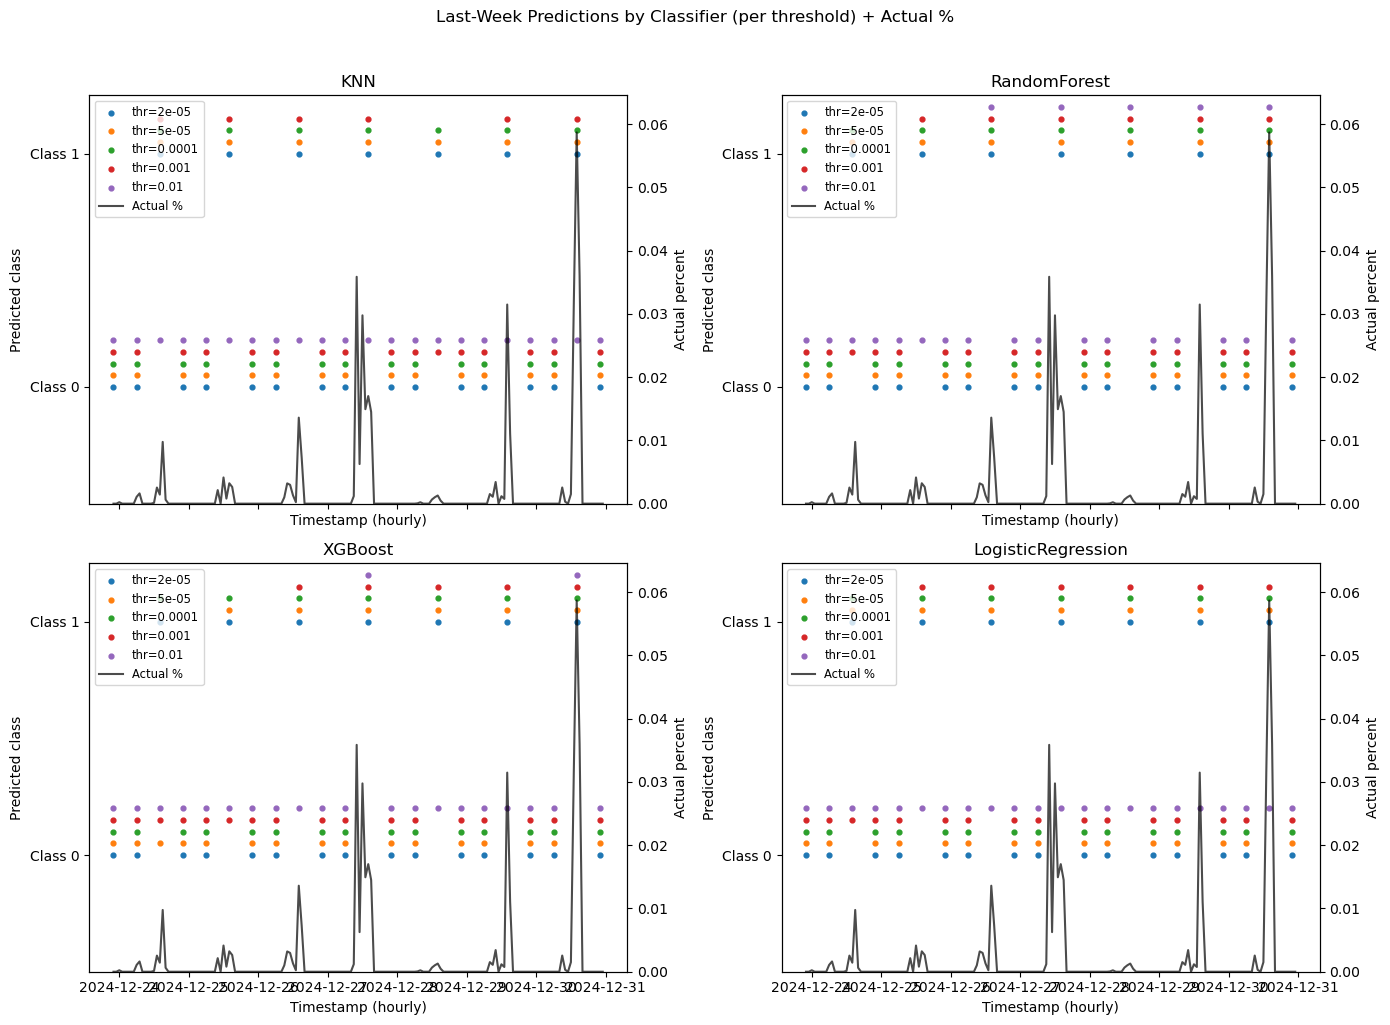

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.pipeline       import Pipeline
from sklearn.impute         import SimpleImputer
from sklearn.preprocessing  import StandardScaler
from sklearn.neighbors      import KNeighborsClassifier
from sklearn.ensemble       import RandomForestClassifier
from xgboost                import XGBClassifier
from sklearn.linear_model   import LogisticRegression

# 1) Prepare features & target
X = fd.drop(columns=['percent'], errors='ignore')
y_cont = fd['percent']

# drop any row with missing data
X_clean = X.dropna(axis=0, how='any')
y_clean = y_cont.loc[X_clean.index]

# 2) Define thresholds, CV splitter, models, scoring
thresholds = [0.00002, 0.00005, 0.0001, 0.001, 0.01]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models = {
    'KNN': Pipeline([
        ('imp',   SimpleImputer(strategy='median')),
        ('scale', StandardScaler()),
        ('mdl',   KNeighborsClassifier(n_neighbors=5))
    ]),
    'RandomForest': Pipeline([
        ('imp', SimpleImputer(strategy='median')),
        ('mdl', RandomForestClassifier(n_estimators=100, random_state=42))
    ]),
    'XGBoost': Pipeline([
        ('imp', SimpleImputer(strategy='median')),
        ('mdl', XGBClassifier(use_label_encoder=False,
                              eval_metric='logloss',
                              random_state=42))
    ]),
    'LogisticRegression': Pipeline([
        ('imp',   SimpleImputer(strategy='median')),
        ('scale', StandardScaler()),
        ('mdl',   LogisticRegression(max_iter=1000, random_state=42))
    ]),
}

scoring = [
    'accuracy',
    'roc_auc',
    'precision',
    'recall',
    'f1',
    'average_precision',    # PR-AUC
    'balanced_accuracy',
    'neg_log_loss',
    'neg_brier_score',
]

# 3) Cross-validate over thresholds & models
results = []
for thr in thresholds:
    y = (y_clean > thr).astype(int)
    print(f"\nThreshold {thr}: class balance →", 
          y.value_counts(normalize=True).to_dict())
    for name, pipe in models.items():
        cv_res = cross_validate(pipe, X_clean, y,
                                cv=cv,
                                scoring=scoring,
                                return_train_score=False)
        row = {'threshold': thr, 'model': name}
        for metric in scoring:
            row[f"{metric}_mean"] = cv_res[f"test_{metric}"].mean()
        results.append(row)

results_df = pd.DataFrame(results)
print("\nCross-validation summary:\n", results_df)

# 4) Hold-out: last 7 days (168 h)
last_ts    = X_clean.index.max()
test_start = (last_ts - pd.Timedelta(days=7)).ceil('H')
train_end  = test_start - pd.Timedelta(hours=1)

X_train    = X_clean.loc[:train_end]
X_test     = X_clean.loc[test_start:]
y_train_ct = y_clean.loc[:train_end]
y_test_cont= y_cont.loc[test_start:]

# Gather predictions for that week
preds = pd.DataFrame(index=X_test.index)
for thr in thresholds:
    y_train = (y_train_ct > thr).astype(int)
    for name, pipe in models.items():
        pipe.fit(X_train, y_train)
        preds[f"{name}_thr_{thr}"] = pipe.predict(X_test)

import matplotlib.pyplot as plt

# preds: DataFrame of shape (hours_in_last_week × (4*len(thresholds)))  
# y_test_cont: Series of actual percent over the last week  
# thresholds: your list of thresholds  
# models: dict of your four pipelines, e.g. {'KNN':…, 'RandomForest':…, …}

fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True)
axes = axes.flatten()

for ax, model_name in zip(axes, models.keys()):
    # scatter each threshold for this classifier
    for i, thr in enumerate(thresholds):
        col = f"{model_name}_thr_{thr}"
        offset = i * 0.05
        ax.scatter(
            preds.index,
            preds[col] + offset,
            s=12,
            label=f"thr={thr}"
        )
    
    ax.set_title(model_name)
    ax.set_yticks([0,1])
    ax.set_yticklabels(['Class 0','Class 1'])
    ax.set_ylim(-0.5, 1 + 0.05*len(thresholds))
    ax.set_ylabel("Predicted class")
    
    # overlay actual percent on twin y-axis
    ax2 = ax.twinx()
    line, = ax2.plot(
        y_test_cont.index,
        y_test_cont,
        color='black',
        lw=1.5,
        alpha=0.7,
        label='Actual %'
    )
    ax2.set_ylabel("Actual percent")
    ax2.set_ylim(y_test_cont.min()*0.9, y_test_cont.max()*1.1)
    
    # combine legends
    h1, l1 = ax.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax.legend(h1 + [line], l1 + l2, loc='upper left', fontsize='small')

# common x-label and title
for ax in axes:
    ax.set_xlabel("Timestamp (hourly)")

fig.suptitle("Last‐Week Predictions by Classifier (per threshold) + Actual %", y=1.02)
plt.tight_layout()
plt.show()

In [81]:
df.columns

Index(['load_forecast_load_forecast', 'net_load', 'renewables',
       'renewables_to_load_ratio', 'load_load', 'fuel_mix_solar',
       'fuel_mix_wind', 'fuel_mix_geothermal', 'fuel_mix_biomass',
       'fuel_mix_biogas', 'fuel_mix_small_hydro', 'fuel_mix_coal',
       'fuel_mix_nuclear', 'fuel_mix_natural_gas', 'fuel_mix_large_hydro',
       'fuel_mix_batteries', 'fuel_mix_imports', 'fuel_mix_other',
       'total_generation', 'load_forecast', 'net_load_forecast', 'solar_mw',
       'wind_mw', 'total_curtailment_mw', 'solar_curtailment_mw',
       'wind_curtailment_mw', 'lmp', 'energy', 'congestion', 'loss', 'ghg',
       'lmp_diff', 'energy_diff', 'congestion_diff', 'loss_diff', 'ghg_diff',
       'percent', 'dow_Friday', 'dow_Monday', 'dow_Saturday', 'dow_Sunday',
       'dow_Thursday', 'dow_Tuesday', 'dow_Wednesday', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12', 'hour_0', 'hour_1

In [82]:
ff = df.drop(['net_load', 'renewables', 'renewables_to_load_ratio', 'load_load', 'fuel_mix_solar',
       'fuel_mix_wind', 'fuel_mix_geothermal', 'fuel_mix_biomass',
       'fuel_mix_biogas', 'fuel_mix_small_hydro', 'fuel_mix_coal',
       'fuel_mix_nuclear', 'fuel_mix_natural_gas', 'fuel_mix_large_hydro',
       'fuel_mix_batteries', 'fuel_mix_imports', 'fuel_mix_other',
       'total_generation', 'total_curtailment_mw', 'solar_curtailment_mw',
       'wind_curtailment_mw',], axis = 1)

In [83]:
ff.columns

Index(['load_forecast_load_forecast', 'load_forecast', 'net_load_forecast',
       'solar_mw', 'wind_mw', 'lmp', 'energy', 'congestion', 'loss', 'ghg',
       'lmp_diff', 'energy_diff', 'congestion_diff', 'loss_diff', 'ghg_diff',
       'percent', 'dow_Friday', 'dow_Monday', 'dow_Saturday', 'dow_Sunday',
       'dow_Thursday', 'dow_Tuesday', 'dow_Wednesday', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12', 'hour_0', 'hour_1',
       'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8',
       'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14',
       'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20',
       'hour_21', 'hour_22', 'hour_23'],
      dtype='object')


Threshold 2e-05: class balance → {1: 0.5358674182203594, 0: 0.4641325817796406}


C:\Users\REALD\anaconda3\envs\gridstatus\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:13:44] WARNING: D:\bld\xgboost-split_1745056718345\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\REALD\anaconda3\envs\gridstatus\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:13:45] WARNING: D:\bld\xgboost-split_1745056718345\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\REALD\anaconda3\envs\gridstatus\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:13:46] WARNING: D:\bld\xgboost-split_1745056718345\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\REALD\anaconda3\envs\gridstatus\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:13:47] WARNING: D:\bld\xgboost-split_1745056718345\work\src\learner.cc:738: 
Par


Threshold 5e-05: class balance → {1: 0.5301344124873537, 0: 0.46986558751264634}


C:\Users\REALD\anaconda3\envs\gridstatus\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:14:35] WARNING: D:\bld\xgboost-split_1745056718345\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\REALD\anaconda3\envs\gridstatus\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:14:38] WARNING: D:\bld\xgboost-split_1745056718345\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\REALD\anaconda3\envs\gridstatus\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:14:40] WARNING: D:\bld\xgboost-split_1745056718345\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\REALD\anaconda3\envs\gridstatus\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:14:43] WARNING: D:\bld\xgboost-split_1745056718345\work\src\learner.cc:738: 
Par


Threshold 0.0001: class balance → {1: 0.5194392253215783, 0: 0.48056077467842173}


C:\Users\REALD\anaconda3\envs\gridstatus\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:15:32] WARNING: D:\bld\xgboost-split_1745056718345\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\REALD\anaconda3\envs\gridstatus\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:15:33] WARNING: D:\bld\xgboost-split_1745056718345\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\REALD\anaconda3\envs\gridstatus\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:15:34] WARNING: D:\bld\xgboost-split_1745056718345\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\REALD\anaconda3\envs\gridstatus\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:15:36] WARNING: D:\bld\xgboost-split_1745056718345\work\src\learner.cc:738: 
Par


Threshold 0.001: class balance → {0: 0.587079057667293, 1: 0.41292094233270704}


C:\Users\REALD\anaconda3\envs\gridstatus\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:16:20] WARNING: D:\bld\xgboost-split_1745056718345\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\REALD\anaconda3\envs\gridstatus\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:16:21] WARNING: D:\bld\xgboost-split_1745056718345\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\REALD\anaconda3\envs\gridstatus\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:16:21] WARNING: D:\bld\xgboost-split_1745056718345\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\REALD\anaconda3\envs\gridstatus\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:16:22] WARNING: D:\bld\xgboost-split_1745056718345\work\src\learner.cc:738: 
Par


Threshold 0.01: class balance → {0: 0.7662475309534134, 1: 0.2337524690465867}


C:\Users\REALD\anaconda3\envs\gridstatus\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:17:00] WARNING: D:\bld\xgboost-split_1745056718345\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\REALD\anaconda3\envs\gridstatus\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:17:01] WARNING: D:\bld\xgboost-split_1745056718345\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\REALD\anaconda3\envs\gridstatus\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:17:03] WARNING: D:\bld\xgboost-split_1745056718345\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\REALD\anaconda3\envs\gridstatus\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:17:04] WARNING: D:\bld\xgboost-split_1745056718345\work\src\learner.cc:738: 
Par


Cross-validation summary:
     threshold               model  accuracy_mean  roc_auc_mean  \
0     0.00002                 KNN       0.843668      0.914363   
1     0.00002        RandomForest       0.904514      0.966894   
2     0.00002             XGBoost       0.901768      0.963929   
3     0.00002  LogisticRegression       0.874886      0.947273   
4     0.00005                 KNN       0.845980      0.914698   
5     0.00005        RandomForest       0.904996      0.967222   
6     0.00005             XGBoost       0.903406      0.965445   
7     0.00005  LogisticRegression       0.877295      0.948306   
8     0.00010                 KNN       0.852724      0.915737   
9     0.00010        RandomForest       0.907164      0.968670   
10    0.00010             XGBoost       0.905381      0.965947   
11    0.00010  LogisticRegression       0.881148      0.949667   
12    0.00100                 KNN       0.913475      0.953152   
13    0.00100        RandomForest       0.935395

C:\Users\REALD\AppData\Local\Temp\ipykernel_59276\369355126.py:82: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  test_start = (last_ts - pd.Timedelta(days=7)).ceil('H')
C:\Users\REALD\anaconda3\envs\gridstatus\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:17:24] WARNING: D:\bld\xgboost-split_1745056718345\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\REALD\anaconda3\envs\gridstatus\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:17:33] WARNING: D:\bld\xgboost-split_1745056718345\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\REALD\anaconda3\envs\gridstatus\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:17:43] WARNING: D:\bld\xgboost-split_1745056718345\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  

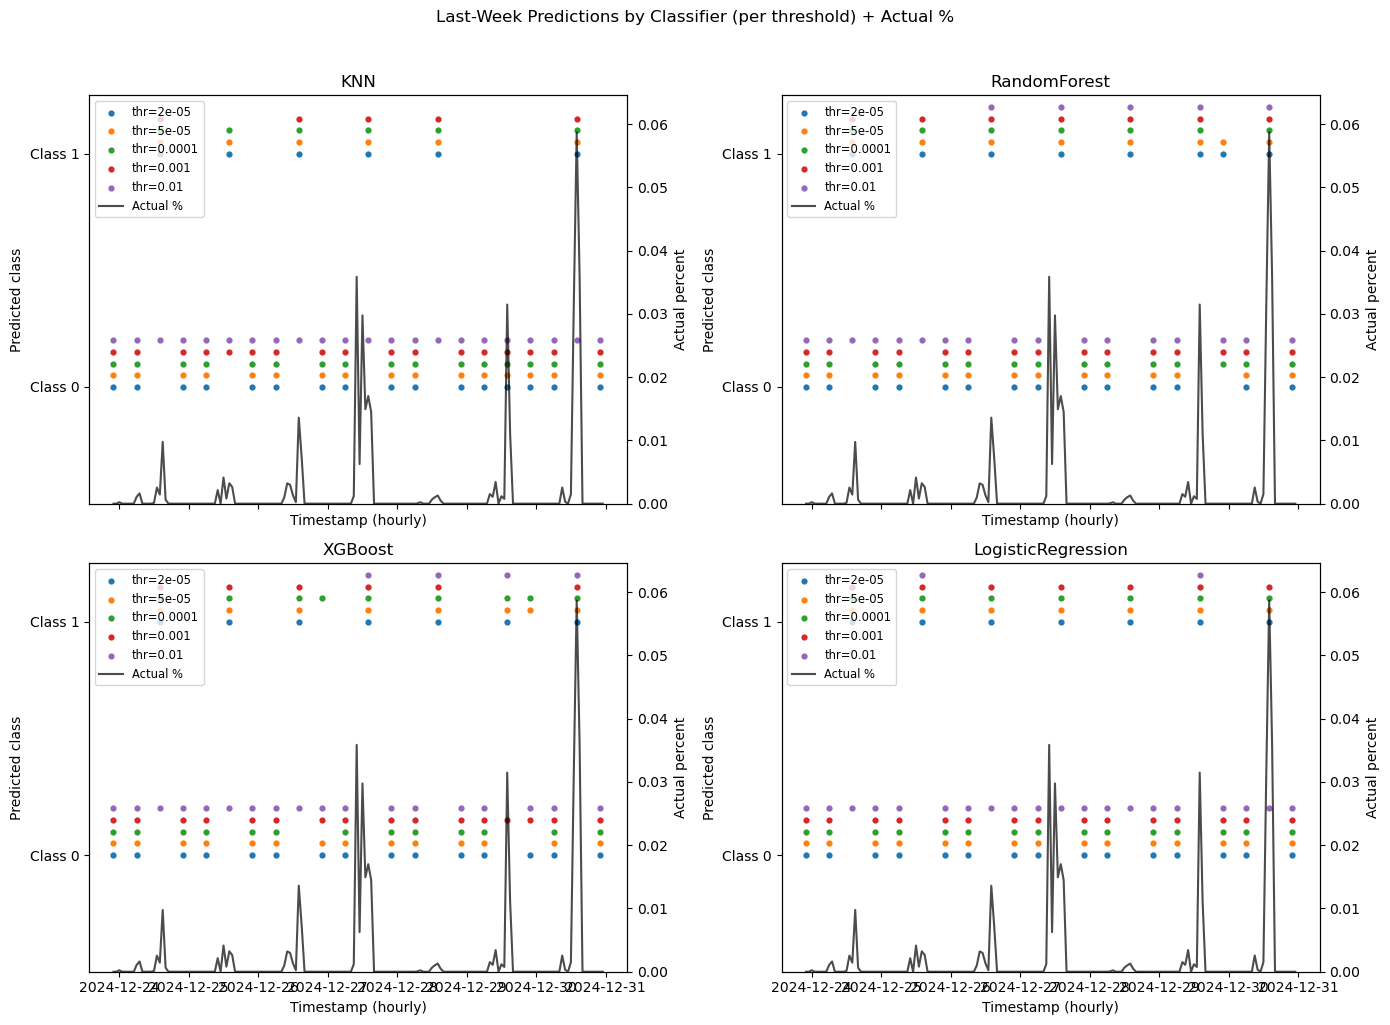

In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.pipeline       import Pipeline
from sklearn.impute         import SimpleImputer
from sklearn.preprocessing  import StandardScaler
from sklearn.neighbors      import KNeighborsClassifier
from sklearn.ensemble       import RandomForestClassifier
from xgboost                import XGBClassifier
from sklearn.linear_model   import LogisticRegression

# 1) Prepare features & target
X = ff.drop(columns=['percent'], errors='ignore')
y_cont = ff['percent']

# drop any row with missing data
X_clean = X.dropna(axis=0, how='any')
y_clean = y_cont.loc[X_clean.index]

# 2) Define thresholds, CV splitter, models, scoring
thresholds = [0.00002, 0.00005, 0.0001, 0.001, 0.01]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models = {
    'KNN': Pipeline([
        ('imp',   SimpleImputer(strategy='median')),
        ('scale', StandardScaler()),
        ('mdl',   KNeighborsClassifier(n_neighbors=5))
    ]),
    'RandomForest': Pipeline([
        ('imp', SimpleImputer(strategy='median')),
        ('mdl', RandomForestClassifier(n_estimators=100, random_state=42))
    ]),
    'XGBoost': Pipeline([
        ('imp', SimpleImputer(strategy='median')),
        ('mdl', XGBClassifier(use_label_encoder=False,
                              eval_metric='logloss',
                              random_state=42))
    ]),
    'LogisticRegression': Pipeline([
        ('imp',   SimpleImputer(strategy='median')),
        ('scale', StandardScaler()),
        ('mdl',   LogisticRegression(max_iter=1000, random_state=42))
    ]),
}

scoring = [
    'accuracy',
    'roc_auc',
    'precision',
    'recall',
    'f1',
    'average_precision',    # PR-AUC
    'balanced_accuracy',
    'neg_log_loss',
    'neg_brier_score',
]

# 3) Cross-validate over thresholds & models
results = []
for thr in thresholds:
    y = (y_clean > thr).astype(int)
    print(f"\nThreshold {thr}: class balance →", 
          y.value_counts(normalize=True).to_dict())
    for name, pipe in models.items():
        cv_res = cross_validate(pipe, X_clean, y,
                                cv=cv,
                                scoring=scoring,
                                return_train_score=False)
        row = {'threshold': thr, 'model': name}
        for metric in scoring:
            row[f"{metric}_mean"] = cv_res[f"test_{metric}"].mean()
        results.append(row)

results_df = pd.DataFrame(results)
print("\nCross-validation summary:\n", results_df)

# 4) Hold-out: last 7 days (168 h)
last_ts    = X_clean.index.max()
test_start = (last_ts - pd.Timedelta(days=7)).ceil('H')
train_end  = test_start - pd.Timedelta(hours=1)

X_train    = X_clean.loc[:train_end]
X_test     = X_clean.loc[test_start:]
y_train_ct = y_clean.loc[:train_end]
y_test_cont= y_cont.loc[test_start:]

# Gather predictions for that week
preds = pd.DataFrame(index=X_test.index)
for thr in thresholds:
    y_train = (y_train_ct > thr).astype(int)
    for name, pipe in models.items():
        pipe.fit(X_train, y_train)
        preds[f"{name}_thr_{thr}"] = pipe.predict(X_test)

import matplotlib.pyplot as plt

# preds: DataFrame of shape (hours_in_last_week × (4*len(thresholds)))  
# y_test_cont: Series of actual percent over the last week  
# thresholds: your list of thresholds  
# models: dict of your four pipelines, e.g. {'KNN':…, 'RandomForest':…, …}

fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True)
axes = axes.flatten()

for ax, model_name in zip(axes, models.keys()):
    # scatter each threshold for this classifier
    for i, thr in enumerate(thresholds):
        col = f"{model_name}_thr_{thr}"
        offset = i * 0.05
        ax.scatter(
            preds.index,
            preds[col] + offset,
            s=12,
            label=f"thr={thr}"
        )
    
    ax.set_title(model_name)
    ax.set_yticks([0,1])
    ax.set_yticklabels(['Class 0','Class 1'])
    ax.set_ylim(-0.5, 1 + 0.05*len(thresholds))
    ax.set_ylabel("Predicted class")
    
    # overlay actual percent on twin y-axis
    ax2 = ax.twinx()
    line, = ax2.plot(
        y_test_cont.index,
        y_test_cont,
        color='black',
        lw=1.5,
        alpha=0.7,
        label='Actual %'
    )
    ax2.set_ylabel("Actual percent")
    ax2.set_ylim(y_test_cont.min()*0.9, y_test_cont.max()*1.1)
    
    # combine legends
    h1, l1 = ax.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax.legend(h1 + [line], l1 + l2, loc='upper left', fontsize='small')

# common x-label and title
for ax in axes:
    ax.set_xlabel("Timestamp (hourly)")

fig.suptitle("Last‐Week Predictions by Classifier (per threshold) + Actual %", y=1.02)
plt.tight_layout()
plt.show()

In [87]:
dd = df.drop(['net_load', 'renewables', 'renewables_to_load_ratio', 'load_load', 'fuel_mix_solar',
       'fuel_mix_wind', 'fuel_mix_geothermal', 'fuel_mix_biomass',
       'fuel_mix_biogas', 'fuel_mix_small_hydro', 'fuel_mix_coal',
       'fuel_mix_nuclear', 'fuel_mix_natural_gas', 'fuel_mix_large_hydro',
       'fuel_mix_batteries', 'fuel_mix_imports', 'fuel_mix_other',
       'total_generation', 'total_curtailment_mw', 'solar_curtailment_mw',
       'wind_curtailment_mw', 'lmp', 'energy', 'congestion', 'loss', 'ghg',
       'lmp_diff', 'energy_diff', 'congestion_diff', 'loss_diff', 'ghg_diff'], axis = 1)

In [88]:
dd.columns

Index(['load_forecast_load_forecast', 'load_forecast', 'net_load_forecast',
       'solar_mw', 'wind_mw', 'percent', 'dow_Friday', 'dow_Monday',
       'dow_Saturday', 'dow_Sunday', 'dow_Thursday', 'dow_Tuesday',
       'dow_Wednesday', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'month_12', 'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5',
       'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
       'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
       'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23'],
      dtype='object')


Threshold 2e-05: class balance → {1: 0.5358501468676266, 0: 0.4641498531323735}


C:\Users\REALD\anaconda3\envs\gridstatus\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:19:38] WARNING: D:\bld\xgboost-split_1745056718345\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\REALD\anaconda3\envs\gridstatus\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:19:39] WARNING: D:\bld\xgboost-split_1745056718345\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\REALD\anaconda3\envs\gridstatus\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:19:40] WARNING: D:\bld\xgboost-split_1745056718345\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\REALD\anaconda3\envs\gridstatus\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:19:42] WARNING: D:\bld\xgboost-split_1745056718345\work\src\learner.cc:738: 
Par


Threshold 5e-05: class balance → {1: 0.5301199017672269, 0: 0.46988009823277316}


C:\Users\REALD\anaconda3\envs\gridstatus\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:20:26] WARNING: D:\bld\xgboost-split_1745056718345\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\REALD\anaconda3\envs\gridstatus\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:20:27] WARNING: D:\bld\xgboost-split_1745056718345\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\REALD\anaconda3\envs\gridstatus\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:20:28] WARNING: D:\bld\xgboost-split_1745056718345\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\REALD\anaconda3\envs\gridstatus\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:20:29] WARNING: D:\bld\xgboost-split_1745056718345\work\src\learner.cc:738: 
Par


Threshold 0.0001: class balance → {1: 0.5193817113689989, 0: 0.4806182886310011}


C:\Users\REALD\anaconda3\envs\gridstatus\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:20:58] WARNING: D:\bld\xgboost-split_1745056718345\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\REALD\anaconda3\envs\gridstatus\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:20:59] WARNING: D:\bld\xgboost-split_1745056718345\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\REALD\anaconda3\envs\gridstatus\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:20:59] WARNING: D:\bld\xgboost-split_1745056718345\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\REALD\anaconda3\envs\gridstatus\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:21:03] WARNING: D:\bld\xgboost-split_1745056718345\work\src\learner.cc:738: 
Par


Threshold 0.001: class balance → {0: 0.5870852795300235, 1: 0.4129147204699764}


C:\Users\REALD\anaconda3\envs\gridstatus\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:21:35] WARNING: D:\bld\xgboost-split_1745056718345\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\REALD\anaconda3\envs\gridstatus\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:21:35] WARNING: D:\bld\xgboost-split_1745056718345\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\REALD\anaconda3\envs\gridstatus\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:21:35] WARNING: D:\bld\xgboost-split_1745056718345\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\REALD\anaconda3\envs\gridstatus\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:21:36] WARNING: D:\bld\xgboost-split_1745056718345\work\src\learner.cc:738: 
Par


Threshold 0.01: class balance → {0: 0.7662156305677277, 1: 0.23378436943227235}


C:\Users\REALD\anaconda3\envs\gridstatus\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:22:02] WARNING: D:\bld\xgboost-split_1745056718345\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\REALD\anaconda3\envs\gridstatus\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:22:03] WARNING: D:\bld\xgboost-split_1745056718345\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\REALD\anaconda3\envs\gridstatus\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:22:03] WARNING: D:\bld\xgboost-split_1745056718345\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\REALD\anaconda3\envs\gridstatus\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:22:03] WARNING: D:\bld\xgboost-split_1745056718345\work\src\learner.cc:738: 
Par


Cross-validation summary:
     threshold               model  accuracy_mean  roc_auc_mean  \
0     0.00002                 KNN       0.845717      0.914127   
1     0.00002        RandomForest       0.878557      0.951859   
2     0.00002             XGBoost       0.880676      0.953020   
3     0.00002  LogisticRegression       0.872538      0.946267   
4     0.00005                 KNN       0.851688      0.915646   
5     0.00005        RandomForest       0.881880      0.953251   
6     0.00005             XGBoost       0.882121      0.953932   
7     0.00005  LogisticRegression       0.874175      0.947282   
8     0.00010                 KNN       0.856166      0.917110   
9     0.00010        RandomForest       0.884769      0.953919   
10    0.00010             XGBoost       0.884432      0.955485   
11    0.00010  LogisticRegression       0.879231      0.948683   
12    0.00100                 KNN       0.915154      0.951671   
13    0.00100        RandomForest       0.928830

C:\Users\REALD\AppData\Local\Temp\ipykernel_59276\2629772962.py:82: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  test_start = (last_ts - pd.Timedelta(days=7)).ceil('H')
C:\Users\REALD\anaconda3\envs\gridstatus\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:22:14] WARNING: D:\bld\xgboost-split_1745056718345\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\REALD\anaconda3\envs\gridstatus\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:22:20] WARNING: D:\bld\xgboost-split_1745056718345\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\REALD\anaconda3\envs\gridstatus\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:22:28] WARNING: D:\bld\xgboost-split_1745056718345\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

 

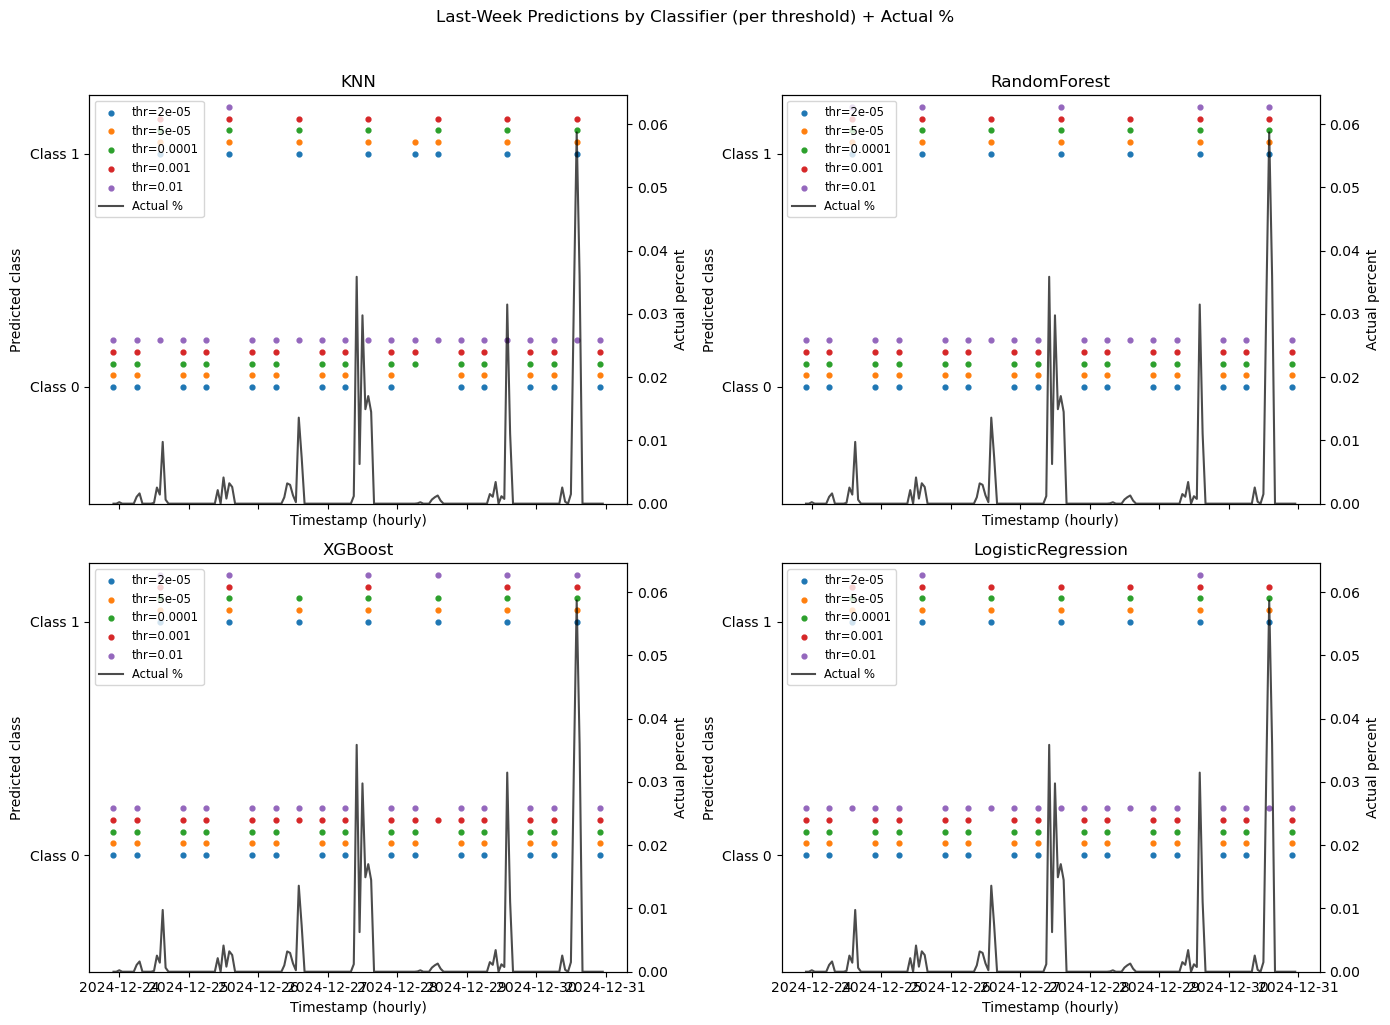

In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.pipeline       import Pipeline
from sklearn.impute         import SimpleImputer
from sklearn.preprocessing  import StandardScaler
from sklearn.neighbors      import KNeighborsClassifier
from sklearn.ensemble       import RandomForestClassifier
from xgboost                import XGBClassifier
from sklearn.linear_model   import LogisticRegression

# 1) Prepare features & target
X = dd.drop(columns=['percent'], errors='ignore')
y_cont = dd['percent']

# drop any row with missing data
X_clean = X.dropna(axis=0, how='any')
y_clean = y_cont.loc[X_clean.index]

# 2) Define thresholds, CV splitter, models, scoring
thresholds = [0.00002, 0.00005, 0.0001, 0.001, 0.01]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models = {
    'KNN': Pipeline([
        ('imp',   SimpleImputer(strategy='median')),
        ('scale', StandardScaler()),
        ('mdl',   KNeighborsClassifier(n_neighbors=5))
    ]),
    'RandomForest': Pipeline([
        ('imp', SimpleImputer(strategy='median')),
        ('mdl', RandomForestClassifier(n_estimators=100, random_state=42))
    ]),
    'XGBoost': Pipeline([
        ('imp', SimpleImputer(strategy='median')),
        ('mdl', XGBClassifier(use_label_encoder=False,
                              eval_metric='logloss',
                              random_state=42))
    ]),
    'LogisticRegression': Pipeline([
        ('imp',   SimpleImputer(strategy='median')),
        ('scale', StandardScaler()),
        ('mdl',   LogisticRegression(max_iter=1000, random_state=42))
    ]),
}

scoring = [
    'accuracy',
    'roc_auc',
    'precision',
    'recall',
    'f1',
    'average_precision',    # PR-AUC
    'balanced_accuracy',
    'neg_log_loss',
    'neg_brier_score',
]

# 3) Cross-validate over thresholds & models
results = []
for thr in thresholds:
    y = (y_clean > thr).astype(int)
    print(f"\nThreshold {thr}: class balance →", 
          y.value_counts(normalize=True).to_dict())
    for name, pipe in models.items():
        cv_res = cross_validate(pipe, X_clean, y,
                                cv=cv,
                                scoring=scoring,
                                return_train_score=False)
        row = {'threshold': thr, 'model': name}
        for metric in scoring:
            row[f"{metric}_mean"] = cv_res[f"test_{metric}"].mean()
        results.append(row)

results_df = pd.DataFrame(results)
print("\nCross-validation summary:\n", results_df)

# 4) Hold-out: last 7 days (168 h)
last_ts    = X_clean.index.max()
test_start = (last_ts - pd.Timedelta(days=7)).ceil('H')
train_end  = test_start - pd.Timedelta(hours=1)

X_train    = X_clean.loc[:train_end]
X_test     = X_clean.loc[test_start:]
y_train_ct = y_clean.loc[:train_end]
y_test_cont= y_cont.loc[test_start:]

# Gather predictions for that week
preds = pd.DataFrame(index=X_test.index)
for thr in thresholds:
    y_train = (y_train_ct > thr).astype(int)
    for name, pipe in models.items():
        pipe.fit(X_train, y_train)
        preds[f"{name}_thr_{thr}"] = pipe.predict(X_test)

import matplotlib.pyplot as plt

# preds: DataFrame of shape (hours_in_last_week × (4*len(thresholds)))  
# y_test_cont: Series of actual percent over the last week  
# thresholds: your list of thresholds  
# models: dict of your four pipelines, e.g. {'KNN':…, 'RandomForest':…, …}

fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True)
axes = axes.flatten()

for ax, model_name in zip(axes, models.keys()):
    # scatter each threshold for this classifier
    for i, thr in enumerate(thresholds):
        col = f"{model_name}_thr_{thr}"
        offset = i * 0.05
        ax.scatter(
            preds.index,
            preds[col] + offset,
            s=12,
            label=f"thr={thr}"
        )
    
    ax.set_title(model_name)
    ax.set_yticks([0,1])
    ax.set_yticklabels(['Class 0','Class 1'])
    ax.set_ylim(-0.5, 1 + 0.05*len(thresholds))
    ax.set_ylabel("Predicted class")
    
    # overlay actual percent on twin y-axis
    ax2 = ax.twinx()
    line, = ax2.plot(
        y_test_cont.index,
        y_test_cont,
        color='black',
        lw=1.5,
        alpha=0.7,
        label='Actual %'
    )
    ax2.set_ylabel("Actual percent")
    ax2.set_ylim(y_test_cont.min()*0.9, y_test_cont.max()*1.1)
    
    # combine legends
    h1, l1 = ax.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax.legend(h1 + [line], l1 + l2, loc='upper left', fontsize='small')

# common x-label and title
for ax in axes:
    ax.set_xlabel("Timestamp (hourly)")

fig.suptitle("Last‐Week Predictions by Classifier (per threshold) + Actual %", y=1.02)
plt.tight_layout()
plt.show()